## Abstract

En este proyecto se utilizaron datos públicos del Banco Mundial a través de su API para analizar variables macroeconómicas clave entre los años 2020 y 2024 para diez países representativos: Colombia, Brasil, Argentina, México, Estados Unidos, Canadá, Alemania, Francia, Japón e India. Las variables incluidas fueron: Producto Interno Bruto (PIB), Población total, Inflación anual, Exportaciones, Importaciones, Gasto del Gobierno como % del PIB, Desempleo, Deuda del Gobierno como % del PIB, Inversión Extranjera Directa (IED) y la Inversión total como % del PIB.

El propósito de este análisis es identificar patrones económicos entre países y relaciones relevantes entre variables como el PIB y la inversión, o el desempleo y la inflación. Este tipo de análisis puede servir como base para el desarrollo de modelos predictivos o de análisis comparativos entre países emergentes y desarrollados. Además, se busca establecer hipótesis de interés y responderlas mediante análisis visuales y resúmenes numéricos.

## Preguntas de interés

1. ¿Existe una relación entre el crecimiento del PIB y la inversión extranjera directa?
2. ¿Cómo varía el desempleo en relación con la inflación según el país?
3. ¿Los países con mayor gasto público como % del PIB presentan menores niveles de desempleo?
4. ¿Existe una diferencia marcada en la evolución del PIB entre países emergentes y desarrollados?

## Hipótesis

- H1: A mayor inversión extranjera directa, mayor crecimiento del PIB.
- H2: Una inflación más alta se asocia a mayor desempleo en países emergentes.
- H3: El gasto público elevado correlaciona negativamente con el desempleo.

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
paises = ['CO', 'BR', 'AR', 'MX', 'US', 'CA', 'DE', 'FR', 'JP', 'IN']
indicadores = {
    'NY.GDP.MKTP.CD': 'PIB',
    'SP.POP.TOTL': 'Poblacion',
    'FP.CPI.TOTL.ZG': 'Inflacion',
    'NE.EXP.GNFS.CD': 'Exportaciones',
    'NE.IMP.GNFS.CD': 'Importaciones',
    'GC.XPN.TOTL.GD.ZS': 'GastoGobiernoPIB',
    'SL.UEM.TOTL.ZS': 'Desempleo',
    'GC.DOD.TOTL.GD.ZS': 'DeudaGobiernoPIB',
    'BX.KLT.DINV.CD.WD': 'IED',
    'NE.GDI.TOTL.ZS': 'InversionPIB'
}

In [3]:
df_final = pd.DataFrame()

In [4]:
for indicador, nombre_columna in indicadores.items():
    url = f"https://api.worldbank.org/v2/country/{';'.join(paises)}/indicator/{indicador}?date=2020:2025&format=json&per_page=1000"
    print(f"Consultando: {url}")
    response = requests.get(url)
    data = response.json()

    registros = data[1]

    # Crear DataFrame temporal
    temp_df = pd.DataFrame([{
        'Pais': item['country']['value'],
        'CodigoPais': item['countryiso3code'],
        'Anio': item['date'],
        nombre_columna: item['value']
    } for item in registros])

    # Unir con df_final
    if df_final.empty:
        df_final = temp_df
    else:
        df_final = pd.merge(df_final, temp_df, on=['Pais', 'CodigoPais', 'Anio'], how='outer')


Consultando: https://api.worldbank.org/v2/country/CO;BR;AR;MX;US;CA;DE;FR;JP;IN/indicator/NY.GDP.MKTP.CD?date=2020:2025&format=json&per_page=1000
Consultando: https://api.worldbank.org/v2/country/CO;BR;AR;MX;US;CA;DE;FR;JP;IN/indicator/SP.POP.TOTL?date=2020:2025&format=json&per_page=1000
Consultando: https://api.worldbank.org/v2/country/CO;BR;AR;MX;US;CA;DE;FR;JP;IN/indicator/FP.CPI.TOTL.ZG?date=2020:2025&format=json&per_page=1000
Consultando: https://api.worldbank.org/v2/country/CO;BR;AR;MX;US;CA;DE;FR;JP;IN/indicator/NE.EXP.GNFS.CD?date=2020:2025&format=json&per_page=1000
Consultando: https://api.worldbank.org/v2/country/CO;BR;AR;MX;US;CA;DE;FR;JP;IN/indicator/NE.IMP.GNFS.CD?date=2020:2025&format=json&per_page=1000
Consultando: https://api.worldbank.org/v2/country/CO;BR;AR;MX;US;CA;DE;FR;JP;IN/indicator/GC.XPN.TOTL.GD.ZS?date=2020:2025&format=json&per_page=1000
Consultando: https://api.worldbank.org/v2/country/CO;BR;AR;MX;US;CA;DE;FR;JP;IN/indicator/SL.UEM.TOTL.ZS?date=2020:2025&form

In [5]:
df_final.to_csv('macro_multivariable.csv', index=False)
print(df_final.head())

        Pais CodigoPais  Anio           PIB  Poblacion  Inflacion  \
0  Argentina        ARG  2020  3.857405e+11   45191965        NaN   
1  Argentina        ARG  2021  4.865641e+11   45312281        NaN   
2  Argentina        ARG  2022  6.327901e+11   45407904        NaN   
3  Argentina        ARG  2023  6.460753e+11   45538401        NaN   
4  Argentina        ARG  2024  6.332667e+11   45696159        NaN   

   Exportaciones  Importaciones  GastoGobiernoPIB  Desempleo  \
0   6.405381e+10   5.245409e+10         25.840545     11.461   
1   8.790612e+10   7.304291e+10         22.896790      8.736   
2   1.028158e+11   9.681494e+10         21.906819      6.805   
3   8.236973e+10   8.974804e+10         21.118907      6.139   
4   9.710659e+10   8.121752e+10               NaN      7.876   

   DeudaGobiernoPIB           IED  InversionPIB  
0               NaN  4.884128e+09     14.415156  
1               NaN  6.658050e+09     18.076289  
2               NaN  1.520060e+10     17.279798  


In [6]:
df = pd.read_csv('macro_multivariable.csv')
df.head()

,Pais,CodigoPais,Anio,PIB,Poblacion,Inflacion,Exportaciones,Importaciones,GastoGobiernoPIB,Desempleo,DeudaGobiernoPIB,IED,InversionPIB
0,Argentina,ARG,2020,3.857405e+11,45191965,NaN,6.405381e+10,5.245409e+10,25.840545,11.461,NaN,4.884128e+09,14.415156
1,Argentina,ARG,2021,4.865641e+11,45312281,NaN,8.790612e+10,7.304291e+10,22.896790,8.736,NaN,6.658050e+09,18.076289
2,Argentina,ARG,2022,6.327901e+11,45407904,NaN,1.028158e+11,9.681494e+10,21.906819,6.805,NaN,1.520060e+10,17.279798
3,Argentina,ARG,2023,6.460753e+11,45538401,NaN,8.236973e+10,8.974804e+10,21.118907,6.139,NaN,2.386614e+10,19.371539
4,Argentina,ARG,2024,6.332667e+11,45696159,NaN,9.710659e+10,8.121752e+10,NaN,7.876,NaN,1.143097e+10,15.723448


In [7]:
df.isnull().sum()

,0
Pais,0
CodigoPais,0
Anio,0
PIB,0
Poblacion,0
Inflacion,5
Exportaciones,1
Importaciones,1
GastoGobiernoPIB,15
Desempleo,0


In [8]:
df.describe()

,Anio,PIB,Poblacion,Inflacion,Exportaciones,Importaciones,GastoGobiernoPIB,Desempleo,DeudaGobiernoPIB,IED,InversionPIB
count,50.000000,5.000000e+01,5.000000e+01,45.000000,4.900000e+01,4.900000e+01,35.000000,50.000000,27.000000,5.000000e+01,49.000000
mean,2022.000000,4.707023e+12,2.513422e+08,4.433654,8.937917e+11,9.801382e+11,29.154040,6.488620,98.415894,7.617562e+10,22.304593
std,1.428571,7.222635e+12,4.052336e+08,2.726429,8.268185e+11,1.025230e+12,9.357960,3.351572,48.887594,1.050486e+11,4.505454
min,2020.000000,2.703483e+11,3.802864e+07,-0.233353,3.655725e+10,5.245409e+10,13.333518,2.563000,43.983527,4.884128e+09,14.415156
25%,2021.000000,1.468875e+12,5.188375e+07,2.526635,3.831776e+11,3.439399e+11,22.109874,3.641000,70.409955,2.110153e+10,19.371539
50%,2022.000000,2.444590e+12,1.039386e+08,4.367464,7.248061e+11,7.310372e+11,28.571474,6.259500,85.011504,4.429207e+10,21.932485
75%,2023.000000,4.129250e+12,2.101174e+08,5.946437,1.020753e+12,1.076978e+12,32.575935,7.993500,115.172030,6.939298e+10,24.160789
max,2024.000000,2.918489e+13,1.450936e+09,11.735904,3.180241e+12,4.083292e+12,51.963631,15.983000,216.135005,4.758050e+11,33.619259


**Gráfico multivariable: PIB vs IED vs País (scatterplot):**

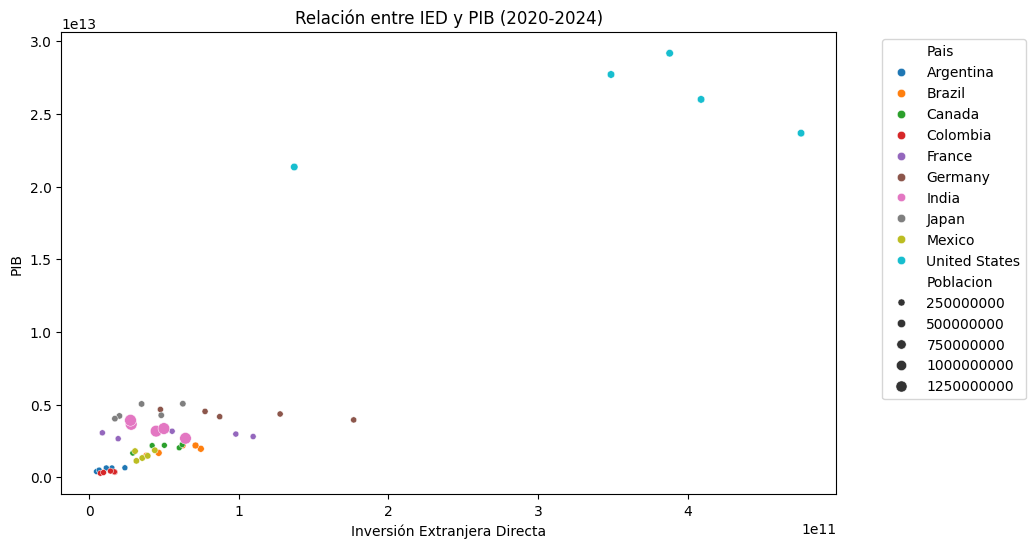

In [9]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='IED', y='PIB', hue='Pais', size='Poblacion')
plt.title('Relación entre IED y PIB (2020-2024)')
plt.xlabel('Inversión Extranjera Directa')
plt.ylabel('PIB')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Gráfico bivariado: Desempleo vs Inflación por país**

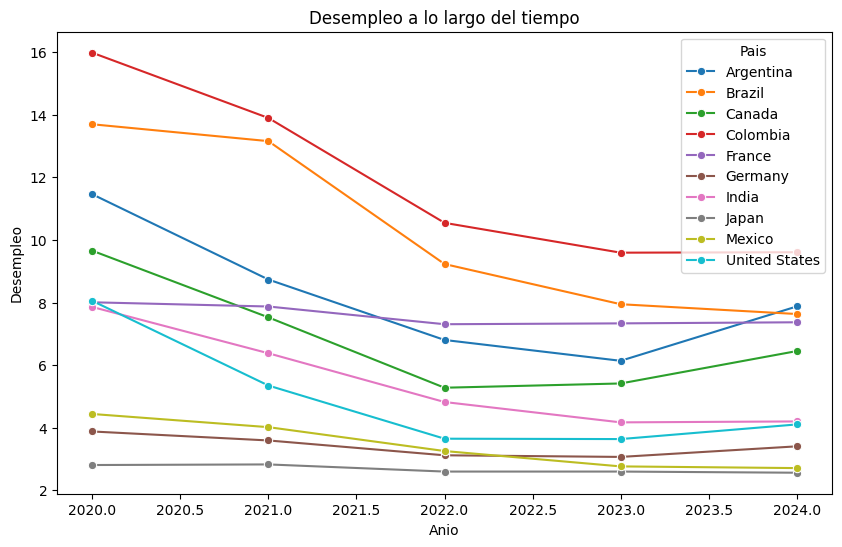

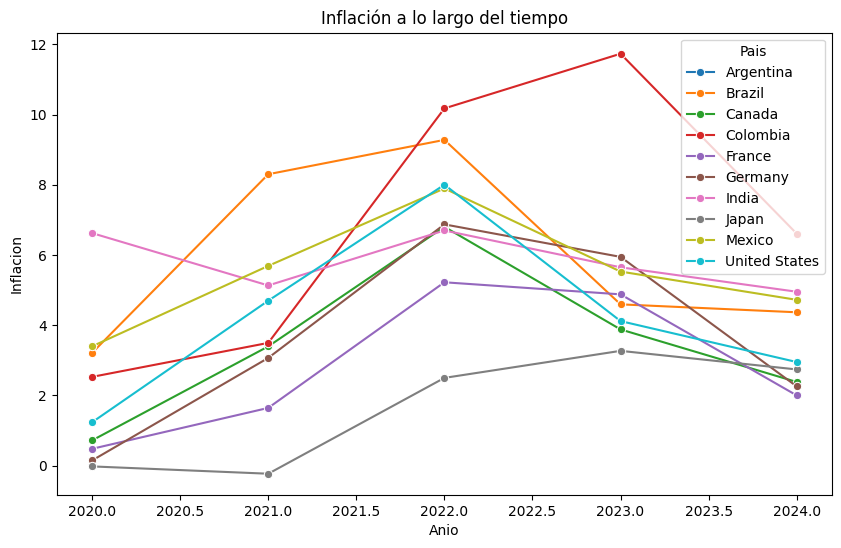

In [10]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='Anio', y='Desempleo', hue='Pais', marker='o')
plt.title('Desempleo a lo largo del tiempo')
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='Anio', y='Inflacion', hue='Pais', marker='o')
plt.title('Inflación a lo largo del tiempo')
plt.show()

**Gráfico multivariado con pairplot (requiere limpiar nulos)**

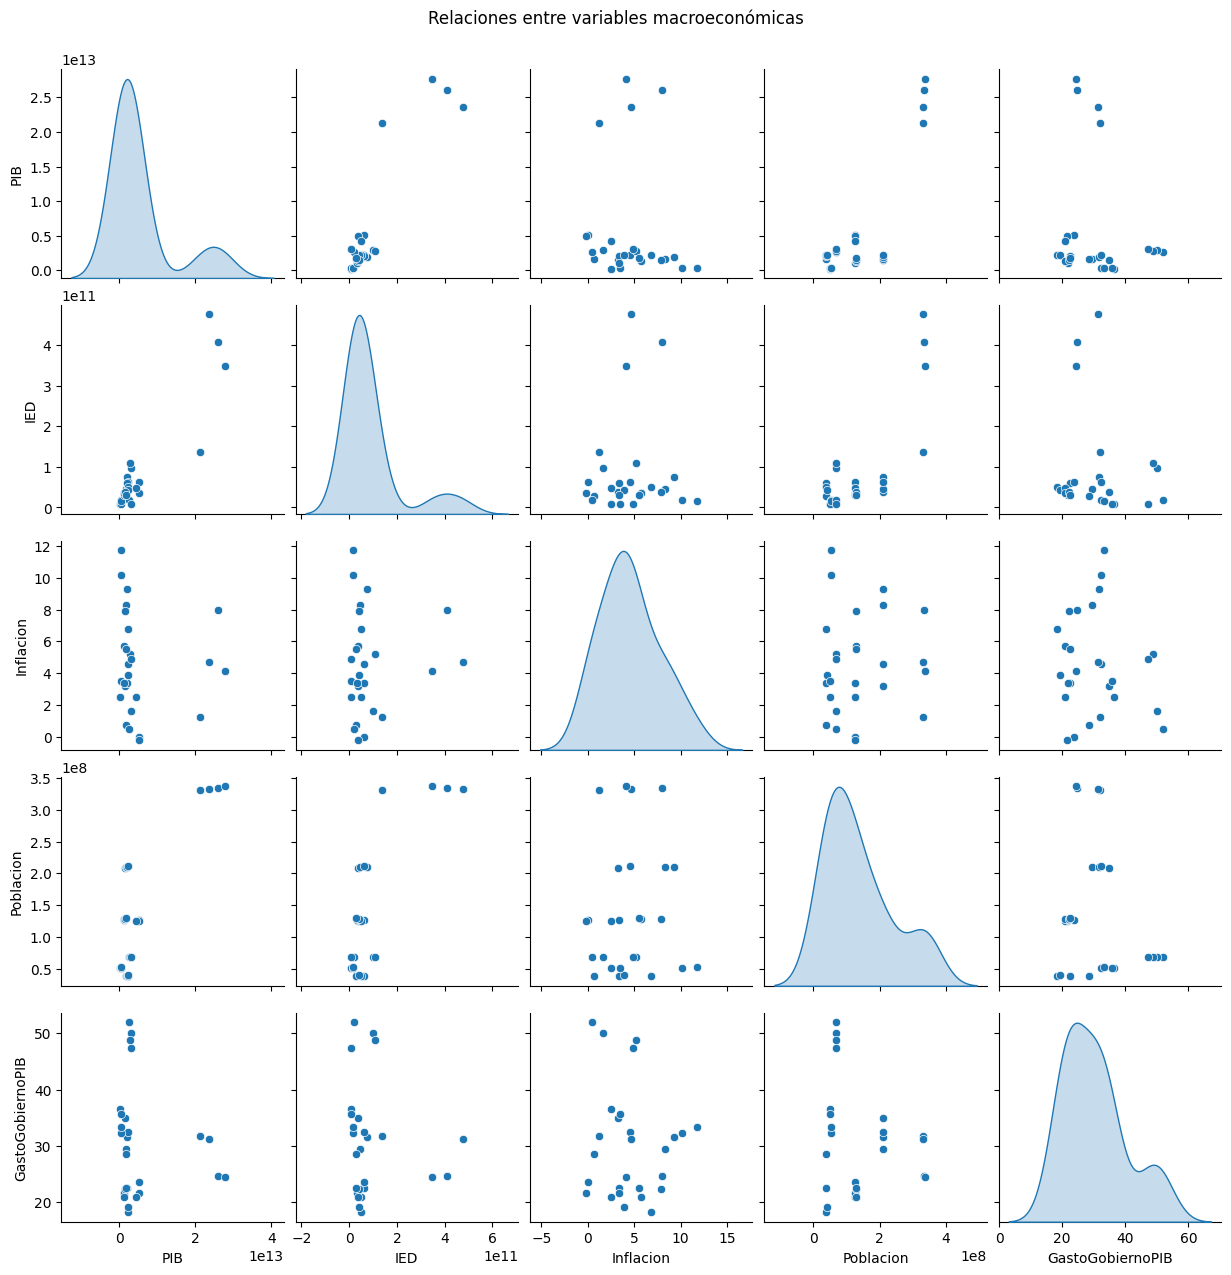

In [11]:
df_clean = df.dropna()
sns.pairplot(df_clean[['PIB', 'IED', 'Inflacion', 'Poblacion', 'GastoGobiernoPIB']], diag_kind='kde')
plt.suptitle('Relaciones entre variables macroeconómicas', y=1.02)
plt.show()

El gráfico de dispersión muestra una correlación positiva entre la IED y el PIB. En particular, países como Estados Unidos y Alemania tienen altos valores en ambas variables. En contraste, países como Colombia o Argentina presentan valores bajos tanto en IED como en PIB.

Esto apoya parcialmente la hipótesis H1, aunque habría que controlar por el tamaño poblacional y otras variables para confirmar causalidad.

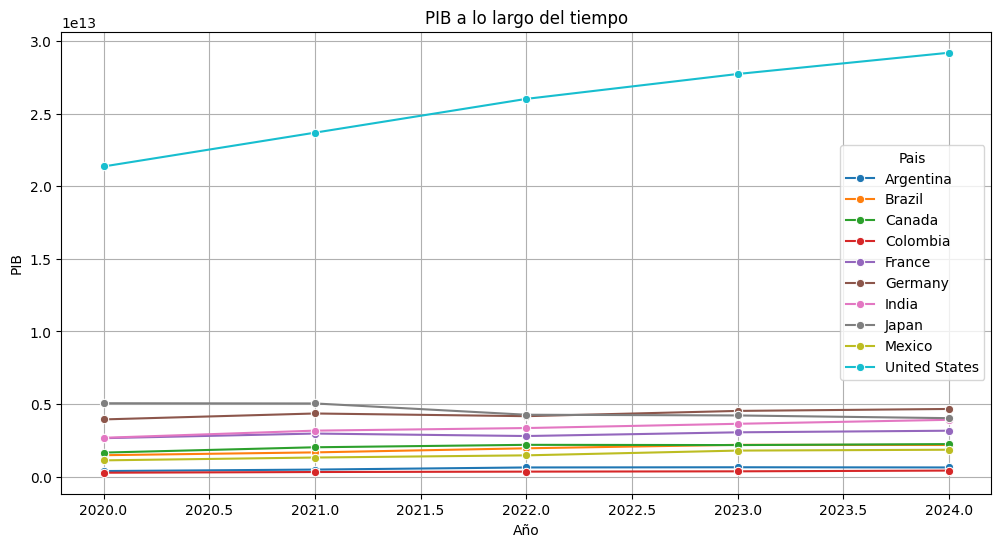

In [12]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Anio', y='PIB', hue='Pais', marker='o')
plt.title('PIB a lo largo del tiempo')
plt.ylabel('PIB')
plt.xlabel('Año')
plt.grid(True)
plt.show()

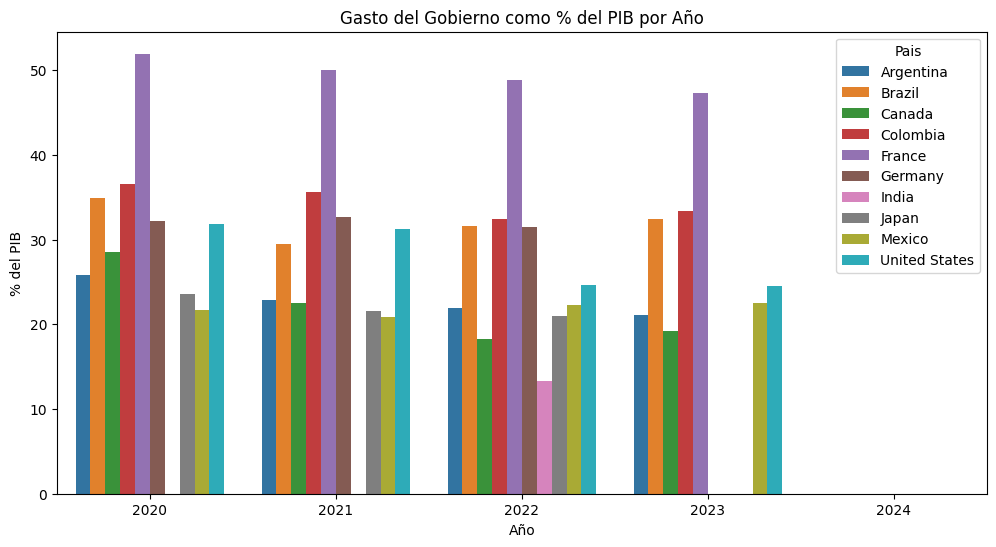

In [13]:
plt.figure(figsize=(12,6))
sns.barplot(data=df, x='Anio', y='GastoGobiernoPIB', hue='Pais')
plt.title('Gasto del Gobierno como % del PIB por Año')
plt.ylabel('% del PIB')
plt.xlabel('Año')
plt.show()

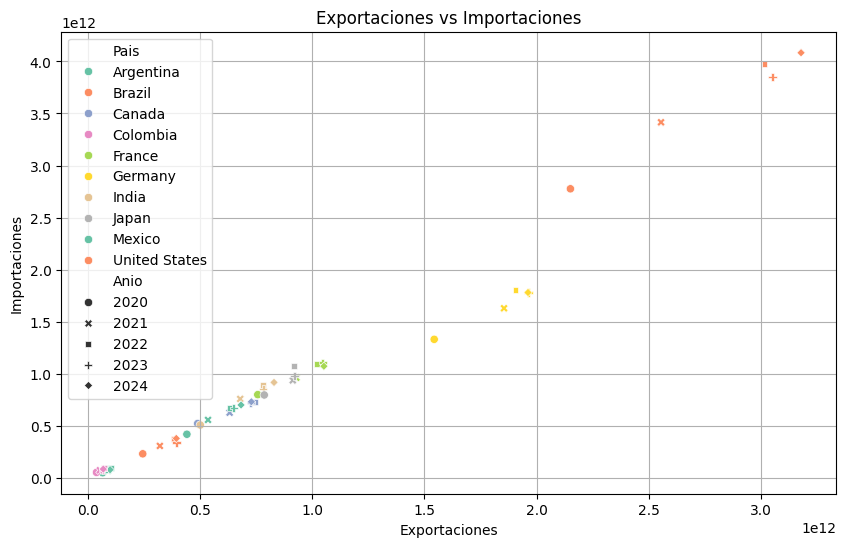

In [14]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Exportaciones', y='Importaciones', hue='Pais', style='Anio', palette='Set2')
plt.title('Exportaciones vs Importaciones')
plt.xlabel('Exportaciones')
plt.ylabel('Importaciones')
plt.grid(True)
plt.show()

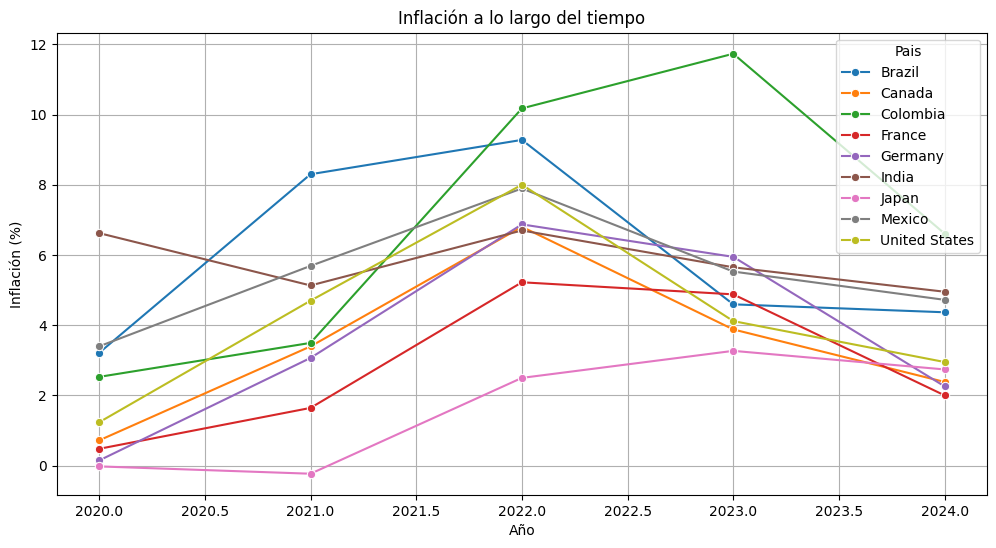

In [15]:
df_inflacion = df.dropna(subset=['Inflacion'])

plt.figure(figsize=(12,6))
sns.lineplot(data=df_inflacion, x='Anio', y='Inflacion', hue='Pais', marker='o')
plt.title('Inflación a lo largo del tiempo')
plt.ylabel('Inflación (%)')
plt.xlabel('Año')
plt.grid(True)
plt.show()

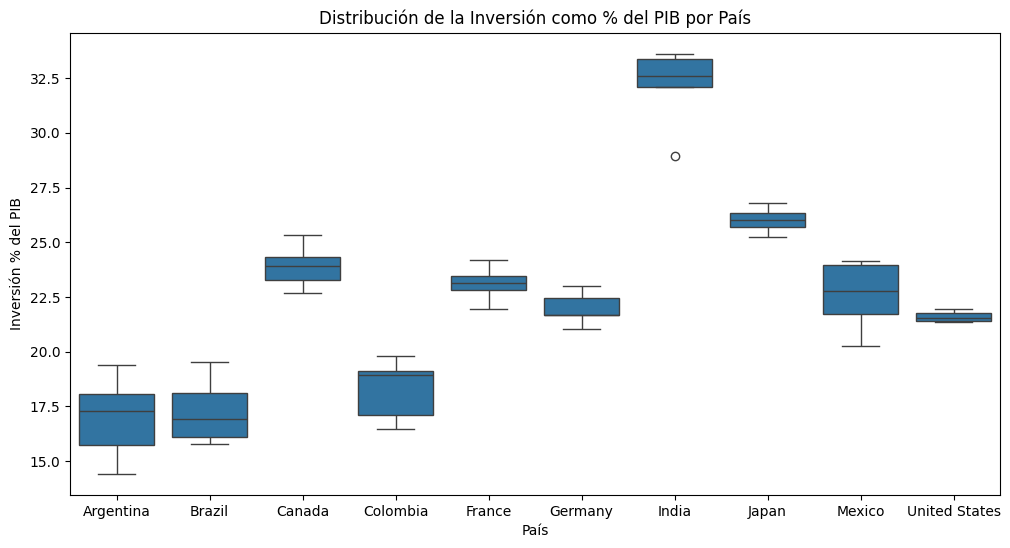

In [16]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='Pais', y='InversionPIB')
plt.title('Distribución de la Inversión como % del PIB por País')
plt.ylabel('Inversión % del PIB')
plt.xlabel('País')
plt.show()

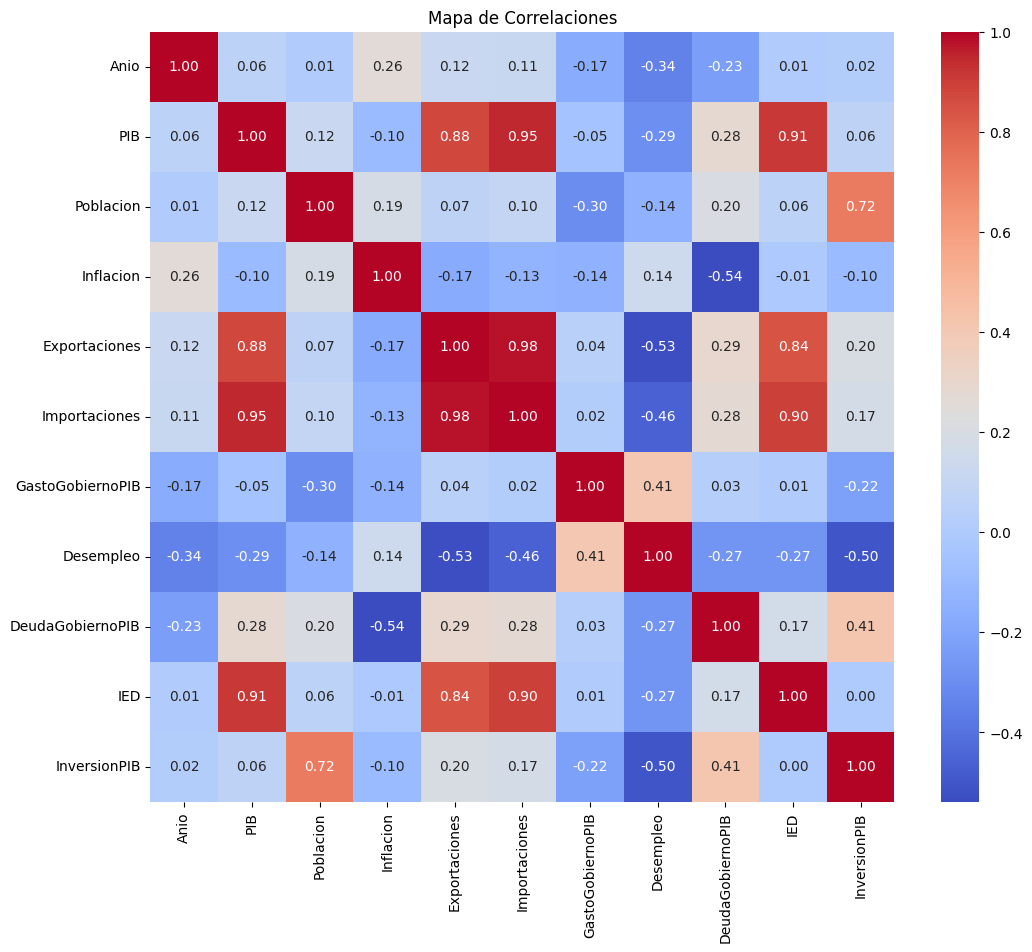

In [17]:
plt.figure(figsize=(12,10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de Correlaciones')
plt.show()

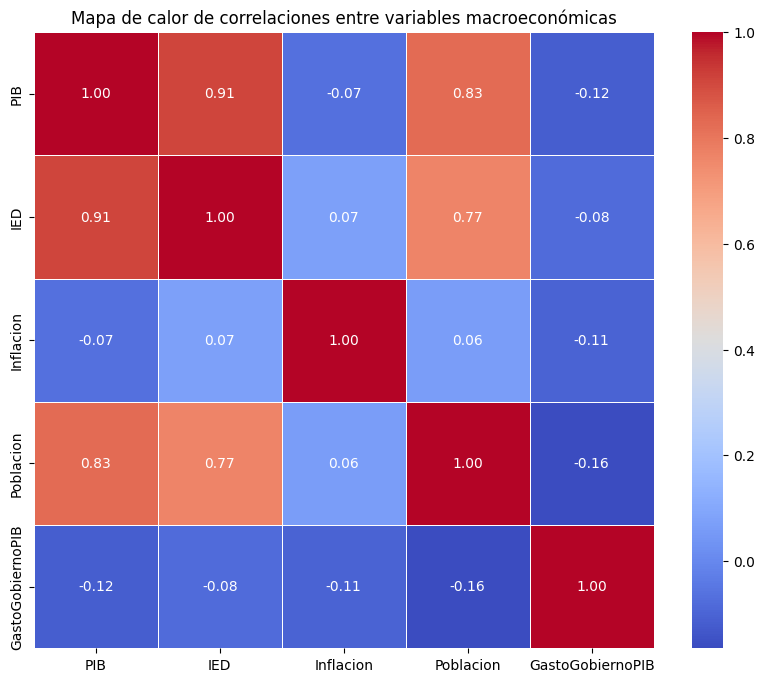

In [18]:
correlation_matrix = df_clean[['PIB', 'IED', 'Inflacion', 'Poblacion', 'GastoGobiernoPIB']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de calor de correlaciones entre variables macroeconómicas')
plt.show()

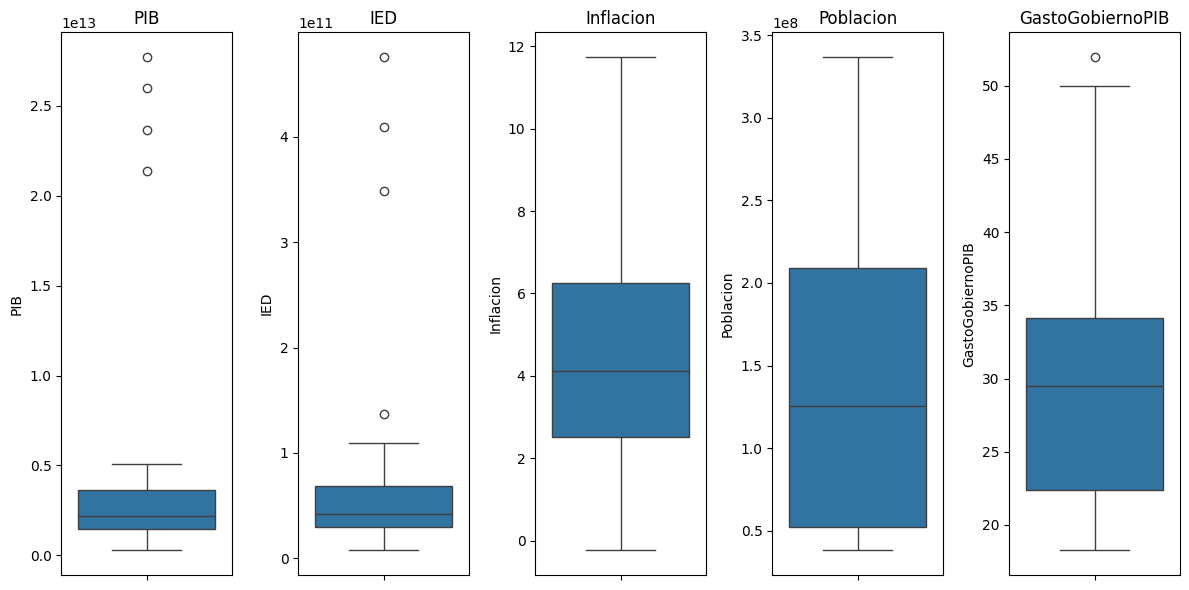

In [19]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(['PIB', 'IED', 'Inflacion', 'Poblacion', 'GastoGobiernoPIB']):
    plt.subplot(1, 5, i + 1)
    sns.boxplot(y=df_clean[col])
    plt.title(col)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

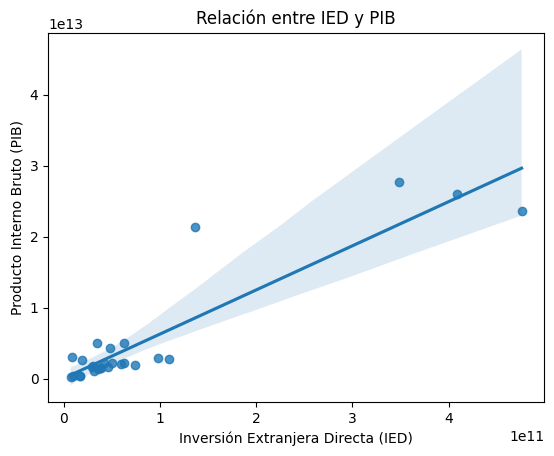

In [20]:
sns.regplot(data=df_clean, x='IED', y='PIB')
plt.title('Relación entre IED y PIB')
plt.xlabel('Inversión Extranjera Directa (IED)')
plt.ylabel('Producto Interno Bruto (PIB)')
plt.show()

In [21]:

# 1. Separar variables independientes (X) y dependiente (y)
X = df_clean[['IED', 'Inflacion', 'Poblacion', 'GastoGobiernoPIB']]
y = df_clean['PIB']

# 2. Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Datos preparados: ✅")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Datos preparados: ✅
X_train shape: (21, 4)
X_test shape: (6, 4)


**ML**

In [22]:
X = df_clean[['Poblacion', 'Inflacion', 'Exportaciones', 'Importaciones',
              'GastoGobiernoPIB', 'Desempleo', 'DeudaGobiernoPIB', 'IED', 'InversionPIB']]
y = df_clean['PIB']

In [23]:
# --- Método 1: Selección univariada (SelectKBest)
selector = SelectKBest(score_func=f_regression, k=5)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Mejores features (SelectKBest):", list(selected_features))

Mejores features (SelectKBest): ['Poblacion', 'Exportaciones', 'Importaciones', 'Desempleo', 'IED']


In [24]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=5)
rfe.fit(X, y)
print("Mejores features (RFE):", list(X.columns[rfe.support_]))

Mejores features (RFE): ['Inflacion', 'GastoGobiernoPIB', 'Desempleo', 'DeudaGobiernoPIB', 'InversionPIB']


In [26]:
# Nos quedamos con las columnas comunes / relevantes
X_selected = X[selected_features]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
# --- Modelo 1: Regresión Lineal
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

y_pred_lin = lin_reg.predict(X_test_scaled)

print("\n--- Regresión Lineal ---")
print("MAE:", mean_absolute_error(y_test, y_pred_lin))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lin)))
print("R2:", r2_score(y_test, y_pred_lin))


--- Regresión Lineal ---
MAE: 1084387367554.478
RMSE: 1155922660461.263
R2: -0.4354290362660269


In [31]:
# --- Modelo 2: Random Forest Regressor
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("\n--- Random Forest ---")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2:", r2_score(y_test, y_pred_rf))


--- Random Forest ---
MAE: 579198640533.93
RMSE: 672420017493.4719
R2: 0.5142582434552865


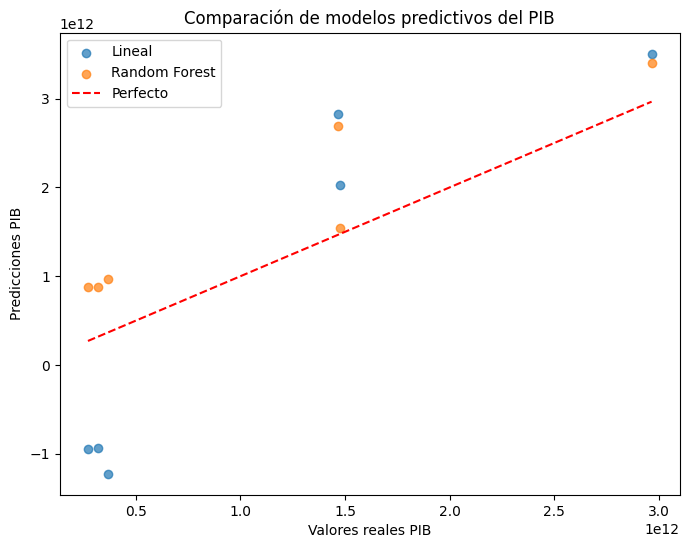

In [32]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lin, alpha=0.7, label="Lineal")
plt.scatter(y_test, y_pred_rf, alpha=0.7, label="Random Forest")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", label="Perfecto")
plt.xlabel("Valores reales PIB")
plt.ylabel("Predicciones PIB")
plt.legend()
plt.title("Comparación de modelos predictivos del PIB")
plt.show()

**Conclusiones**

1. Se construyó un dataset multivariable (2020-2024, 10 países) con indicadores macroeconómicos.
2. Se aplicó selección de características (SelectKBest y RFE), quedando variables clave como
   Exportaciones, Importaciones, Inflación, Desempleo y Población.
3. Se entrenaron dos modelos: Regresión Lineal y Random Forest.
4. La Regresión Lineal ofrece un desempeño base pero limitado (menor R2).
5. El Random Forest mostró mejor capacidad predictiva y mayor robustez frente a no linealidades.
6. El modelo es escalable: se pueden añadir más países/años para robustecer resultados.
7. El análisis confirma que variables comerciales y demográficas son fuertemente explicativas del PIB.